In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import cv2
import sys
import os
import glob

sys.path.insert(0, '..')
from densenet_small import Inference

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from MulticoreTSNE import MulticoreTSNE as MTSNE

colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
labels = ['G3', 'G4', 'G5', 'BN', 'ST']

In [3]:
SNAPSHOT = '../densenet_small/10x/snapshots/densenet.ckpt-30845'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Inference(sess=sess, x_dims = [256, 256, 3])
model.restore(SNAPSHOT)

Requesting 4 dense blocks
MINIMIUM DIMENSION:  8
Setting up densenet in inference mode
DenseNet Model
Non-linearity: <function selu at 0x7f3534b7e230>
	 x_in (?, 256, 256, 3)
Dense block #0 (dd)
	 Transition Down with k_out= 96
Dense block #1 (dd)
	 Transition Down with k_out= 144
Dense block #2 (dd)
	 Transition Down with k_out= 240
Dense block #3 (dense)
	 Bottleneck:  (?, 8, 8, 528)
	 Transition Up with k_out= 264
Dense block #0 (du)
	 Transition Up with k_out= 96
Dense block #1 (du)
	 Transition Up with k_out= 48
Dense block #2 (du)
Model output y_hat: (?, 256, 256, 5)
Restoring from ../densenet_small/10x/snapshots/densenet.ckpt-30845
INFO:tensorflow:Restoring parameters from ../densenet_small/10x/snapshots/densenet.ckpt-30845
Success!


In [4]:
model.downsample_list

[<tf.Tensor 'densenet/concat_down_0:0' shape=(?, 64, 64, 192) dtype=float32>,
 <tf.Tensor 'densenet/concat_down_1:0' shape=(?, 32, 32, 288) dtype=float32>,
 <tf.Tensor 'densenet/concat_down_2:0' shape=(?, 16, 16, 480) dtype=float32>]

## Single images; close to x-space

In [5]:
jpg_list = sorted(glob.glob('/media/ing/D/image_data/segmentation/gleason_grade/cbm_split/train_jpg/*.jpg'))
mask_list = sorted(glob.glob('/media/ing/D/image_data/segmentation/gleason_grade/cbm_split/train_mask/*.png'))
img = cv2.imread(jpg_list[0])[:,:,::-1]
img = img[:256, :256, :]
img = np.expand_dims(img, 0)

rets = sess.run(model.downsample_list + [model.bottleneck] + model.upsample_list + [model.y_hat], 
                {model.x_in: img, model.keep_prob: 1.0})

for K in rets:
    print(K.shape)


(1, 64, 64, 192)
(1, 32, 32, 288)
(1, 16, 16, 480)
(1, 8, 8, 528)
(1, 16, 16, 192)
(1, 32, 32, 96)
(1, 64, 64, 96)
(1, 256, 256, 5)


In [6]:
# jpg_list = sorted(glob.glob('../data/val_jpg/*.jpg'))
# mask_list = sorted(glob.glob('../data/val_mask/*.png'))

jpg_list = sorted(glob.glob('/media/ing/D/image_data/segmentation/gleason_grade/cbm_split/train_jpg/*.jpg'))
mask_list = sorted(glob.glob('/media/ing/D/image_data/segmentation/gleason_grade/cbm_split/train_mask/*.png'))

x0 = 128
y0 = 128
z0_flat = np.empty(shape=(0,192))
z1_flat = np.empty(shape=(0,288))
z2_flat = np.empty(shape=(0,480))
z3_flat = np.empty(shape=(0,528))

zu3_flat = np.empty(shape=(0,192))
zu2_flat = np.empty(shape=(0,96))
zu1_flat = np.empty(shape=(0,96))
zu0_flat = np.empty(shape=(0,5))

y0_flat = np.empty(shape=(0,1), dtype=np.int)
y1_flat = np.empty(shape=(0,1), dtype=np.int)
y2_flat = np.empty(shape=(0,1), dtype=np.int)
y3_flat = np.empty(shape=(0,1), dtype=np.int)
yout_flat = np.empty(shape=(0,1), dtype=np.int)
n = 20

imgs = zip(jpg_list, mask_list)
np.random.shuffle(imgs)

for jpg, mask in imgs[:n]:

    x = cv2.imread(jpg, -1)[:,:,::-1]
    y = cv2.imread(mask, -1)
    y_ = y[x0:x0+512, y0:y0+512]
    x_ = x[x0:x0+512, y0:y0+512]
    x_ = cv2.resize(x_, dsize=(0,0), fx=0.5, fy=0.5)
    x_ = x_ * (2/255.) - 1.
    x_ = np.expand_dims(x_, 0)

    z0, z1, z2, z3, zu3, zu2, zu1, zu0 = sess.run(model.downsample_list + [model.bottleneck] + model.upsample_list + [model.y_hat], 
        feed_dict={model.x_in: x_, model.keep_prob: 1.0})

    z0_flat = np.concatenate([z0_flat, z0.reshape(64*64, 192)], axis=0)
    z1_flat = np.concatenate([z1_flat, z1.reshape(32*32, 288)], axis=0)
    z2_flat = np.concatenate([z2_flat, z2.reshape(16*16, 480)], axis=0)
    z3_flat = np.concatenate([z3_flat, z3.reshape(8*8, 528)], axis=0)
    
    zu3_flat = np.concatenate([zu3_flat, zu3.reshape(16*16, 192)], axis=0)
    zu2_flat = np.concatenate([zu2_flat, zu2.reshape(32*32, 96)], axis=0)
    zu1_flat = np.concatenate([zu1_flat, zu1.reshape(64*64, 96)], axis=0)
    zu0_flat = np.concatenate([zu0_flat, zu0.reshape(256*256, 5)], axis=0)

    y0_ = cv2.resize(y_, dsize=(64, 64), interpolation=cv2.INTER_NEAREST).reshape(64*64, 1).astype(np.int)
    y1_ = cv2.resize(y_, dsize=(32, 32), interpolation=cv2.INTER_NEAREST).reshape(32*32, 1).astype(np.int)
    y2_ = cv2.resize(y_, dsize=(16, 16), interpolation=cv2.INTER_NEAREST).reshape(16*16, 1).astype(np.int)
    y3_ = cv2.resize(y_, dsize=(8, 8), interpolation=cv2.INTER_NEAREST).reshape(8*8, 1).astype(np.int)
    
    y_out = cv2.resize(y_, dsize=(256, 256), interpolation=cv2.INTER_NEAREST).reshape(256*256, 1).astype(np.int)
    
    y0_flat = np.concatenate([y0_flat, y0_.reshape(64*64, 1).astype(np.int)], axis=0)
    y1_flat = np.concatenate([y1_flat, y1_.reshape(32*32, 1).astype(np.int)], axis=0)
    y2_flat = np.concatenate([y2_flat, y2_.reshape(16*16, 1).astype(np.int)], axis=0)
    y3_flat = np.concatenate([y3_flat, y3_.reshape(8*8, 1).astype(np.int)], axis=0)
    yout_flat = np.concatenate([yout_flat, y_out.reshape(256*256, 1).astype(np.int)], axis=0)
    

In [7]:
print('z0_flat', z0_flat.shape)
print('z1_flat', z1_flat.shape)
print('z2_flat', z2_flat.shape)
print('z3_flat', z3_flat.shape)
print('zu3_flat', zu3_flat.shape)
print('zu2_flat', zu2_flat.shape)
print('zu1_flat', zu1_flat.shape)
print('zu0_flat', zu0_flat.shape)

print(y0_flat.shape, np.unique(y0_flat))
print(y1_flat.shape, np.unique(y1_flat))
print(y2_flat.shape, np.unique(y2_flat))
print(y3_flat.shape, np.unique(y3_flat))
print(yout_flat.shape, np.unique(yout_flat))

z0_flat (81920, 192)
z1_flat (20480, 288)
z2_flat (5120, 480)
z3_flat (1280, 528)
zu3_flat (5120, 192)
zu2_flat (20480, 96)
zu1_flat (81920, 96)
zu0_flat (1310720, 5)
(81920, 1) [0 1 2 3 4]
(20480, 1) [0 1 2 3 4]
(5120, 1) [0 1 2 3 4]
(1280, 1) [0 1 2 3 4]
(1310720, 1) [0 1 2 3 4]


In [8]:
x0 = np.empty((0,192))
x1 = np.empty((0,288))
x2 = np.empty((0,480))
x3 = np.empty((0,528))
xu3 = np.empty((0,192))
xu2 = np.empty((0,96))
xu1 = np.empty((0,96))
xu0 = np.empty((0,5))
y0 = []
y1 = []
y2 = []
y3 = []
yu3 = []
yu2 = []
yu1 = []
yu0 = []
n_sample = 1000

for k in range(5):
    z0_class = z0_flat[np.squeeze(y0_flat)==k, :]
    z1_class = z1_flat[np.squeeze(y1_flat)==k, :]
    z2_class = z2_flat[np.squeeze(y2_flat)==k, :]
    z3_class = z3_flat[np.squeeze(y3_flat)==k, :]
    zu3_class = zu3_flat[np.squeeze(y2_flat)==k, :]
    zu2_class = zu2_flat[np.squeeze(y1_flat)==k, :]
    zu1_class = zu1_flat[np.squeeze(y0_flat)==k, :]
    zu0_class = zu0_flat[np.squeeze(yout_flat)==k, :]
    
    n_z0 = z0_class.shape[0]
    n_z1 = z1_class.shape[0]
    n_z2 = z2_class.shape[0]
    n_z3 = z3_class.shape[0]
    n_zu3 = zu3_class.shape[0]
    n_zu2 = zu2_class.shape[0]
    n_zu1 = zu1_class.shape[0]
    n_zu0 = zu0_class.shape[0]
    
    idxs0 = np.arange(n_z0)
    idxs1 = np.arange(n_z1)
    idxs2 = np.arange(n_z2)
    idxs3 = np.arange(n_z3)
    idxsu3 = np.arange(n_z3)
    idxsu2 = np.arange(n_z2)
    idxsu1 = np.arange(n_z1)
    idxsu0 = np.arange(n_z0)
    
    z0_choice = z0_class[np.random.choice(idxs0, 500), :]
    z1_choice = z1_class[np.random.choice(idxs1, 500), :]
    z2_choice = z2_class[np.random.choice(idxs2, 500), :]
    z3_choice = z3_class[np.random.choice(idxs3, 500), :]
    zu3_choice = zu3_class[np.random.choice(idxsu3, 500), :]
    zu2_choice = zu2_class[np.random.choice(idxsu2, 500), :]
    zu1_choice = zu1_class[np.random.choice(idxsu1, 500), :]
    zu0_choice = zu0_class[np.random.choice(idxsu0, 500), :]
    
    x0 = np.concatenate([x0, z0_choice], axis=0)
    x1 = np.concatenate([x1, z1_choice], axis=0)
    x2 = np.concatenate([x2, z2_choice], axis=0)
    x3 = np.concatenate([x3, z3_choice], axis=0)
    xu3 = np.concatenate([xu3, zu3_choice], axis=0)
    xu2 = np.concatenate([xu2, zu2_choice], axis=0)
    xu1 = np.concatenate([xu1, zu1_choice], axis=0)
    xu0 = np.concatenate([xu0, zu0_choice], axis=0)
    
    y0 += [k]*500
    y1 += [k]*500
    y2 += [k]*500
    y3 += [k]*500
    yu3 += [k]*500
    yu2 += [k]*500
    yu1 += [k]*500
    yu0 += [k]*500
    
print('x0 shape', x0.shape)
print('x1 shape', x1.shape)
print('x2 shape', x2.shape)
print('x3 shape', x3.shape)
print('xu0 shape', xu0.shape)
print('xu1 shape', xu1.shape)
print('xu2 shape', xu2.shape)
print('xu3 shape', xu3.shape)

manifold = MTSNE(n_components=2, n_jobs=8)
pr0 = manifold.fit_transform(x0)
print('pr0 shape', pr0.shape)

pr1 = manifold.fit_transform(x1)
print('pr1 shape', pr1.shape)

pr2 = manifold.fit_transform(x2)
print('pr2 shape', pr2.shape)

pr3 = manifold.fit_transform(x3)
print('pr3 shape', pr3.shape)

pru3 = manifold.fit_transform(xu3)
print('pru3 shape', pru3.shape)

pru2 = manifold.fit_transform(xu2)
print('pru2 shape', pru2.shape)

pru1 = manifold.fit_transform(xu1)
print('pru1 shape', pru1.shape)

pru0 = manifold.fit_transform(xu0)
print('pru0 shape', pru0.shape)

x0 shape (2500, 192)
x1 shape (2500, 288)
x2 shape (2500, 480)
x3 shape (2500, 528)
xu0 shape (2500, 5)
xu1 shape (2500, 96)
xu2 shape (2500, 96)
xu3 shape (2500, 192)
pr0 shape (2500, 2)
pr1 shape (2500, 2)
pr2 shape (2500, 2)
pr3 shape (2500, 2)
pru3 shape (2500, 2)
pru2 shape (2500, 2)
pru1 shape (2500, 2)
pru0 shape (2500, 2)


Text(0.5,0.98,'t-SNE')

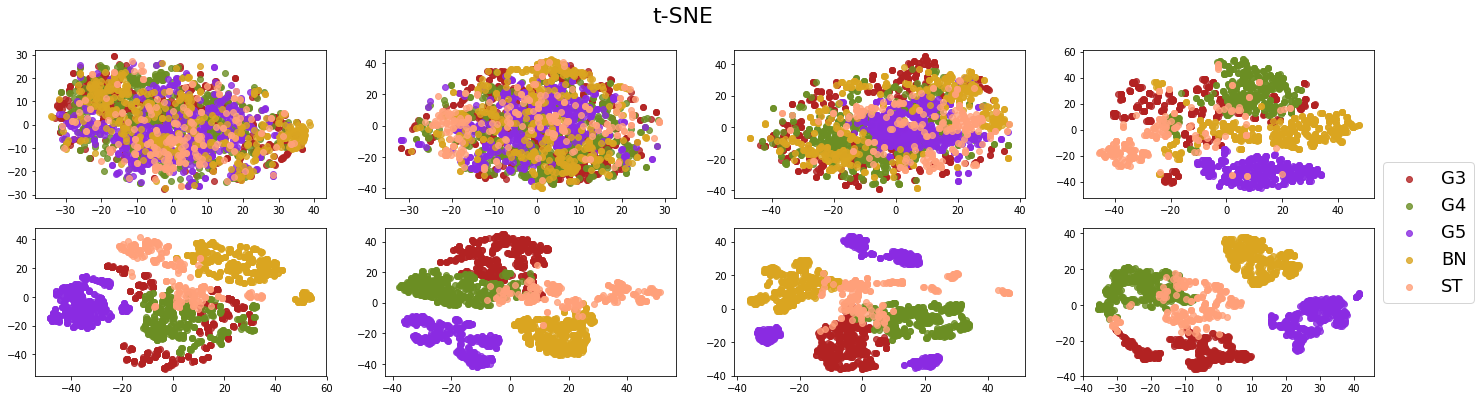

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(24, 6))
# ax = fig.add_subplot(111, projection='3d')
for k in range(5):
    idxs = np.squeeze(np.where(np.asarray(y0)==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
    xs0 = pr0[idxs, 0]
    ys0 = pr0[idxs, 1]
    xs1 = pr1[idxs, 0]
    ys1 = pr1[idxs, 1]
    xs2 = pr2[idxs, 0]
    ys2 = pr2[idxs, 1]
    xs3 = pr3[idxs, 0]
    ys3 = pr3[idxs, 1]
    xsu3 = pru3[idxs, 0]
    ysu3 = pru3[idxs, 1]
    xsu2 = pru2[idxs, 0]
    ysu2 = pru2[idxs, 1]
    xsu1 = pru1[idxs, 0]
    ysu1 = pru1[idxs, 1]
    xsu0 = pru0[idxs, 0]
    ysu0 = pru0[idxs, 1]
    
    sns.regplot(xs0, ys0, fit_reg=False, color=colors[k], label=labels[k], ax=axs[0][0])
    sns.regplot(xs1, ys1, fit_reg=False, color=colors[k], label=labels[k], ax=axs[0][1])
    sns.regplot(xs2, ys2, fit_reg=False, color=colors[k], label=labels[k], ax=axs[0][2])
    sns.regplot(xs3, ys3, fit_reg=False, color=colors[k], label=labels[k], ax=axs[0][3])
    
    sns.regplot(xsu3, ysu3, fit_reg=False, color=colors[k], label=labels[k], ax=axs[1][0])
    sns.regplot(xsu2, ysu2, fit_reg=False, color=colors[k], label=labels[k], ax=axs[1][1])
    sns.regplot(xsu1, ysu1, fit_reg=False, color=colors[k], label=labels[k], ax=axs[1][2])
    sns.regplot(xsu0, ysu0, fit_reg=False, color=colors[k], label=labels[k], ax=axs[1][3])
        
plt.legend(bbox_to_anchor=(1.0, 1.5), fontsize=18)
plt.suptitle('t-SNE', fontsize=22)